In [838]:
pwd

'/Users/aidasaglinskas/Desktop/BC-FacExpr-1.2-fMRI-mainExp'

In [839]:
from matplotlib import pyplot as plt
from PIL import Image, ImageEnhance,ImageStat
import skvideo
import skvideo.io
import numpy as np
import os
from tqdm import tqdm

In [840]:
def load_video(fn):
    videodata = skvideo.io.vread(fn)
    return videodata

In [844]:
files = [os.path.join('./stimuli_cropped/',file) for file in os.listdir('./stimuli_cropped/') if file.endswith('.mp4')]
files.sort()
files[0:5]

['./stimuli_cropped/id1d1.mp4',
 './stimuli_cropped/id1d2.mp4',
 './stimuli_cropped/id1f1.mp4',
 './stimuli_cropped/id1f2.mp4',
 './stimuli_cropped/id1h1.mp4']

In [845]:
len(files)

70

In [846]:
hist_brightness = []
hist_contrast = []
hist_r = []
hist_g = []
hist_b = []
for file in tqdm(files):
    vid = load_video(file)
    hist_brightness.append(  vid[0,:,:,:].mean()  )
    hist_contrast.append(  vid[0,:,:,:].mean(axis=-1).std() )
    
    hist_r.append( vid[0,:,:,0].sum() )
    hist_g.append( vid[0,:,:,1].sum() )
    hist_b.append( vid[0,:,:,2].sum() )

100%|███████████████████████████████████████████| 70/70 [00:11<00:00,  6.28it/s]


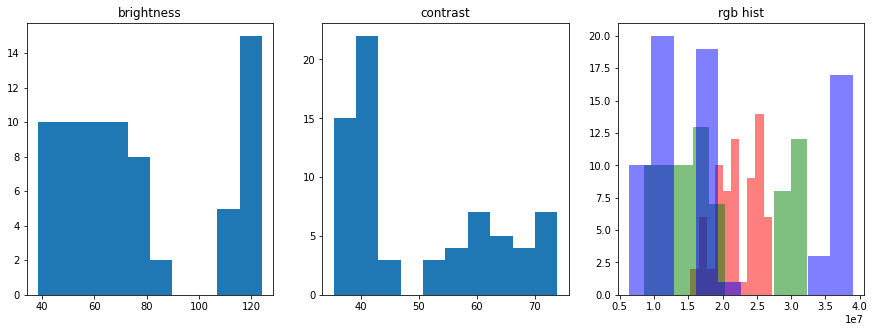

In [847]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(hist_brightness);
plt.title('brightness');
plt.subplot(1,3,2)
plt.hist(hist_contrast);
plt.title('contrast');
plt.subplot(1,3,3)
plt.hist(hist_r,color='r',alpha=.5);
plt.hist(hist_g,color='g',alpha=.5);
plt.hist(hist_b,color='b',alpha=.5);
plt.title('rgb hist');

In [848]:
brightness_target = np.array(hist_brightness).mean()
brightness_target.round(3)

76.97

In [849]:
contrast_target = np.array(hist_contrast).mean()
contrast_target.round(3)

49.997

In [850]:
target_r = np.array(hist_r).mean().astype(int)
target_g = np.array(hist_g).mean().astype(int)
target_b = np.array(hist_b).mean().astype(int)
ctargets = (target_r,target_g,target_b)
ctargets

(22119781, 18559774, 19852422)

In [811]:
l = 50
face_squares = np.array([load_video(files[i])[0,:,:,:][256-l:256+l,256-l:256+l,:] for i in tqdm(range(len(files))) ])
ctargets_faces = face_squares.mean(axis=0).sum(axis=0).sum(axis=0).astype(int)
ctargets_faces

100%|███████████████████████████████████████████| 70/70 [00:09<00:00,  7.12it/s]


array([1693205, 1141272,  924288])

In [953]:
def make_ref(ctargets):
    ref = np.ones((10,10,3))
    for i in range(3):
        ref[:,:,i] = ref[:,:,i] * ctargets[i]
    return ref.astype(np.uint8)

def get_face(frame,l=50):
    return frame[256-l:256+l,256-l:256+l,:]

def get_mean_rbg(frame):
    return frame.mean(axis=0).mean(axis=0)

In [852]:
def brighten_video(videodata,factor=1):
    return np.array([np.array(ImageEnhance.Brightness(Image.fromarray(videodata[frame,:,:,:])).enhance(factor)) for frame in range(videodata.shape[0])])

def contrast_video(videodata,factor=1):
    return np.array([np.array(ImageEnhance.Contrast(Image.fromarray(videodata[frame,:,:,:])).enhance(factor)) for frame in range(videodata.shape[0])])

In [801]:
def get_to_add(frame,channel,ctarget):
    
    to_add = np.zeros((512,512)).astype(int)
    to_add_flat = to_add.reshape(-1)
    potential_add = to_add_flat.copy()
    frame_flat = frame[:,:,channel].flatten()
    
    needs_add = False
    needs_subtract = False
    
    if ctarget-frame_flat.sum() < 0:
        needs_subtract = True    
    elif ctarget-frame_flat.sum() > 0:
        needs_add = True
    else:
        print('wtf')
        
    
    for step in [200_000,10_000,5000,100,1]:
        do_run = True ; i = 0
        while do_run:
            i+=1

            where_2_add1 = ((frame_flat+to_add_flat) < 255) * ((frame_flat+to_add_flat) > 0)
            where_2_add2 = where_2_add1 * (to_add_flat==to_add_flat[where_2_add1].max())

            idx = np.random.permutation(np.nonzero(where_2_add2)[0])[0:step]
            
            if needs_subtract:
                what_to_add = -1
            elif needs_add:
                what_to_add =  1
            else:
                print('no')

            potential_add = to_add_flat.copy()
            potential_add[idx] += what_to_add
            
            if all((needs_subtract,(frame_flat+potential_add).sum() >= ctarget)):
                to_add_flat[idx] += what_to_add
            elif all((needs_add,(frame_flat+potential_add).sum() <= ctarget)):
                to_add_flat[idx] += what_to_add
            else:
                do_run = False
                
    return to_add_flat.reshape(512,512)

In [829]:
def get_to_add_face(frame,channel,ctarget):
    
    to_add = np.zeros((512,512)).astype(int)
    to_add_flat = to_add.reshape(-1)
    potential_add = to_add_flat.copy()
    frame_flat = frame[:,:,channel].flatten()
    
    needs_add = False
    needs_subtract = False
    
    if ctarget-frame[:,:,channel][256-l:256+l,256-l:256+l].sum() < 0:
        needs_subtract = True    
    elif ctarget-frame[:,:,channel][256-l:256+l,256-l:256+l].sum() > 0:
        needs_add = True
    else:
        print('wtf')
        
    
    for step in [200_000,10_000,5000,100,1]:
        do_run = True ; i = 0
        while do_run:
            i+=1

            where_2_add1 = ((frame_flat+to_add_flat) < 255) * ((frame_flat+to_add_flat) > 0)
            where_2_add2 = where_2_add1 * (to_add_flat==to_add_flat[where_2_add1].max())

            idx = np.random.permutation(np.nonzero(where_2_add2)[0])[0:step]
            
            if needs_subtract:
                what_to_add = -1
            elif needs_add:
                what_to_add =  1
            else:
                print('no')

            potential_add = to_add_flat.copy()
            potential_add[idx] += what_to_add
            
            if all((needs_subtract,(frame[:,:,channel][256-l:256+l,256-l:256+l].flatten()+potential_add.reshape(512,512)[256-l:256+l,256-l:256+l].flatten() ).sum() >= ctarget)):
                to_add_flat[idx] += what_to_add
            elif all((needs_add,(frame[:,:,channel][256-l:256+l,256-l:256+l].flatten()+potential_add.reshape(512,512)[256-l:256+l,256-l:256+l].flatten() ).sum() <= ctarget)):
                to_add_flat[idx] += what_to_add
            else:
                do_run = False
                
    return to_add_flat.reshape(512,512)

In [815]:
def adjust_frame_tint(frame,ctargets):
    new_frame = frame.copy()
    new_frame[:,:,0] = new_frame[:,:,0]+get_to_add(frame,0,ctargets[0])
    new_frame[:,:,1] = new_frame[:,:,1]+get_to_add(frame,1,ctargets[1])
    new_frame[:,:,2] = new_frame[:,:,2]+get_to_add(frame,2,ctargets[2])
    
    assert all([new_frame.sum(axis=0).sum(axis=0)[i]==ctargets[i] for i in range(3)]),'mismatch'
    
    return new_frame

In [822]:
def adjust_frame_tint_face(frame,ctargets):
    new_frame = frame.copy()
    new_frame[:,:,0] = new_frame[:,:,0]+get_to_add_face(frame,0,ctargets[0])
    new_frame[:,:,1] = new_frame[:,:,1]+get_to_add_face(frame,1,ctargets[1])
    new_frame[:,:,2] = new_frame[:,:,2]+get_to_add_face(frame,2,ctargets[2])
    
    #assert all([new_frame.sum(axis=0).sum(axis=0)[i]==ctargets[i] for i in range(3)]),'mismatch'
    
    return new_frame

In [816]:
def adjust_frame_tint_diff(frame,ctargets):
    
    new_frame = frame.copy()
    new_frame = np.zeros(new_frame.shape)
    new_frame[:,:,0] = get_to_add(frame,0,ctargets[0])
    new_frame[:,:,1] = get_to_add(frame,1,ctargets[1])
    new_frame[:,:,2] = get_to_add(frame,2,ctargets[2])
    
    #assert all([new_frame.sum(axis=0).sum(axis=0)[i]==ctargets[i] for i in range(3)]),'mismatch'
    
    return new_frame.astype(np.uint8)

In [817]:
def save_video(videodata,ofn='outvideo.mp4'):
    skvideo.io.vwrite(ofn, videodata.astype(np.uint8),outputdict={'-codec': 'h264', '-filter:v' : 'fps=29.97'})

In [975]:
# for i in np.arange(0,70,10):
#     frame = load_video(files[i])[0,:,:,:]
#     new_frame = adjust_frame_tint_face(frame,ctargets_faces)

#     plt.figure(figsize=(10,5))
#     plt.subplot(1,2,1);plt.imshow(frame);plt.xticks([]);plt.yticks([]);
#     plt.subplot(1,2,2);plt.imshow(new_frame);plt.xticks([]);plt.yticks([]);
#     plt.show()

In [855]:
contrast_target

49.99748398061029

In [856]:
brightness_target

76.97039179120746

In [915]:
for i in np.arange(0,70,10):
    print(files[i].replace('stimuli_cropped','stimuli_new_tint'))

./stimuli_new_tint/id1d1.mp4
./stimuli_new_tint/id2d1.mp4
./stimuli_new_tint/id3d1.mp4
./stimuli_new_tint/id4d1.mp4
./stimuli_new_tint/id5d1.mp4
./stimuli_new_tint/id6d1.mp4
./stimuli_new_tint/id7d1.mp4


In [956]:
ctargets_faces

array([1693205, 1141272,  924288])

In [965]:
ctargets_faces = face_squares[0:20,:,:,:].mean(axis=0).sum(axis=0).sum(axis=0).astype(int)
ctargets_faces

array([1496810, 1146717, 1073327])

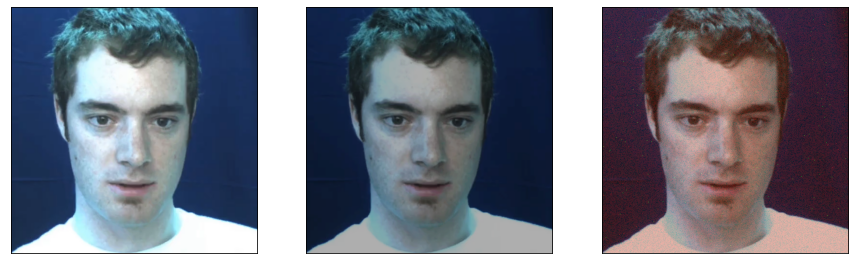

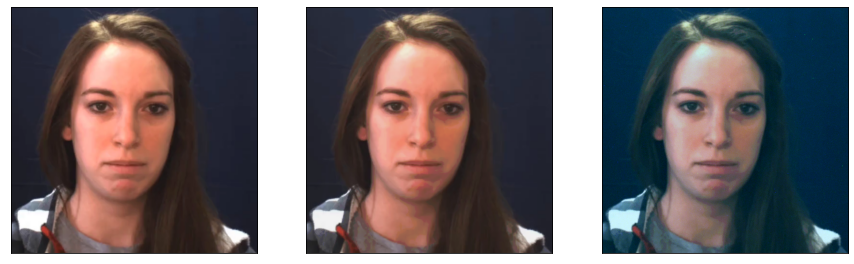

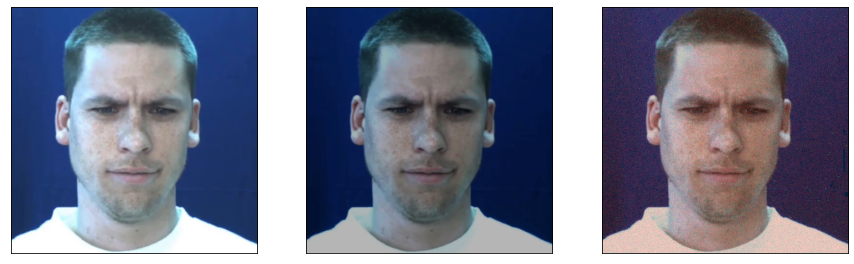

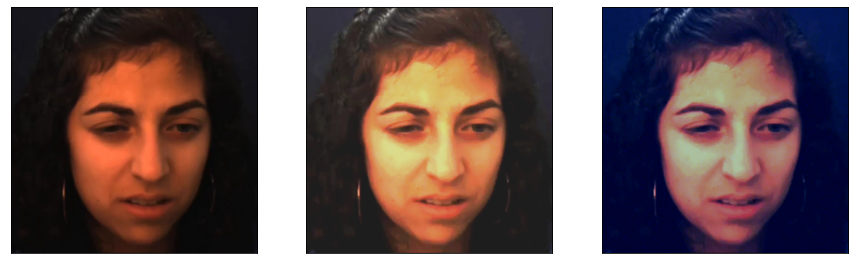

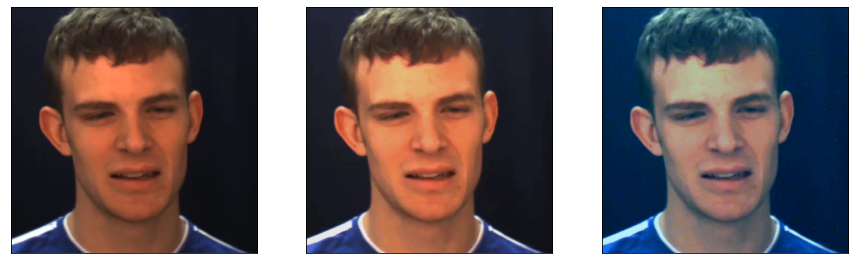

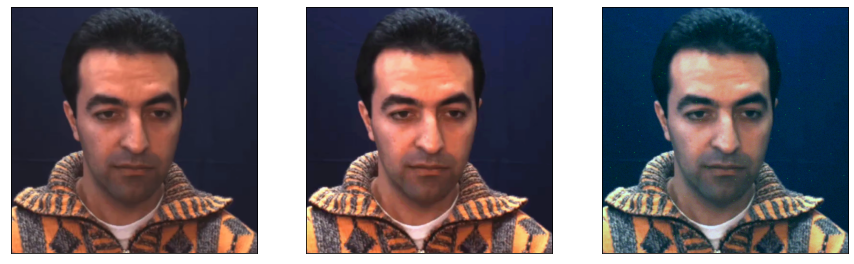

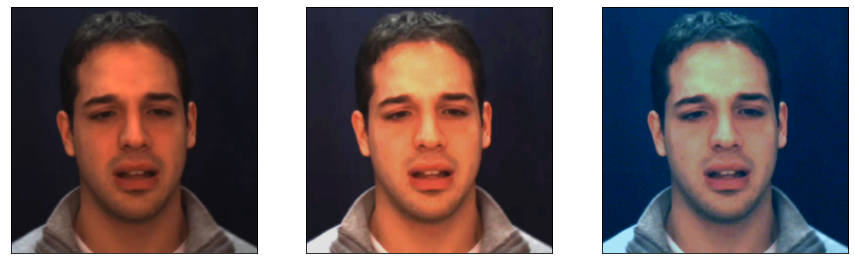

In [974]:
col = []
for i in np.arange(0,70,10):
    
    videodata = load_video(files[i])
    frame_orig = videodata[0,:,:,:].copy()
    
    for j in range(25):
        contrast = videodata[0,:,:,:].mean(axis=-1).std()
        brightness = videodata[0,:,:,:].mean()
        
        videodata = contrast_video(videodata,contrast_target/contrast)
        videodata = brighten_video(videodata,brightness_target/brightness)
    
    frame_bw = videodata[0,:,:,:].copy()
    
    frame = videodata[0,:,:,:]
    new_frame = adjust_frame_tint_face(frame,ctargets_faces)
    
    col.append(new_frame)

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1);plt.imshow(frame_orig);plt.xticks([]);plt.yticks([]);
    plt.subplot(1,3,2);plt.imshow(frame_bw);plt.xticks([]);plt.yticks([]);
    plt.subplot(1,3,3);plt.imshow(new_frame);plt.xticks([]);plt.yticks([]);
    plt.show()
    
    
    # videodata = np.array([adjust_frame_tint_face(videodata[i,:,:,:],ctargets_faces) for i in range(videodata.shape[0])])
    # save_video(videodata,files[i].replace('stimuli_cropped','stimuli_new_tint_face'))
    # print(files[i].replace('stimuli_cropped','stimuli_new_tint_face'))

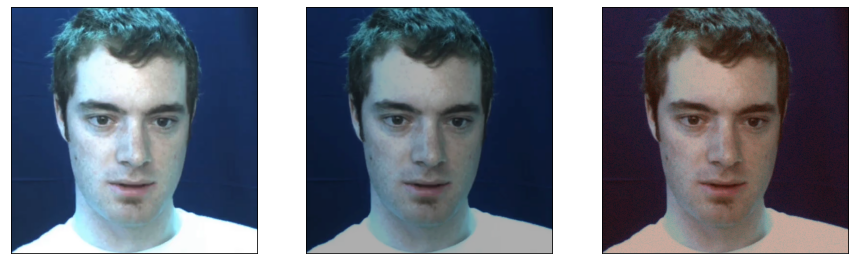

./stimuli_new_tint/id1d1.mp4


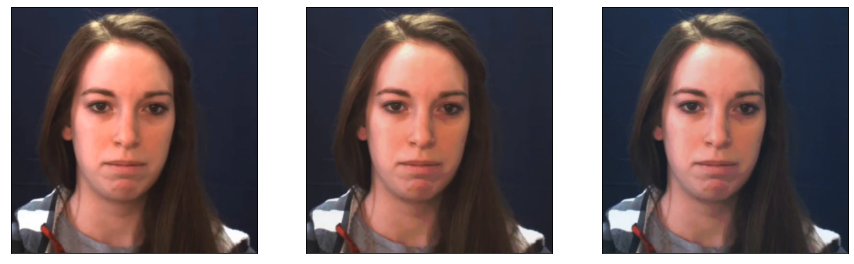

./stimuli_new_tint/id2d1.mp4


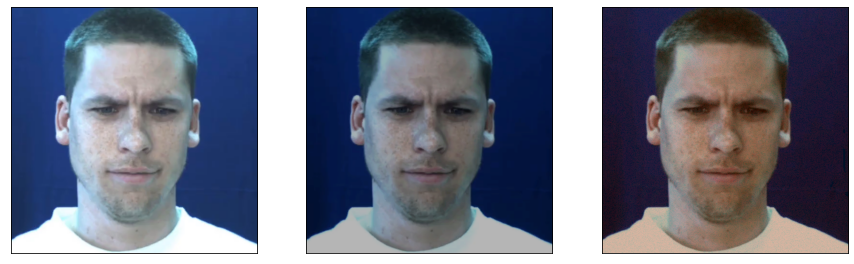

./stimuli_new_tint/id3d1.mp4


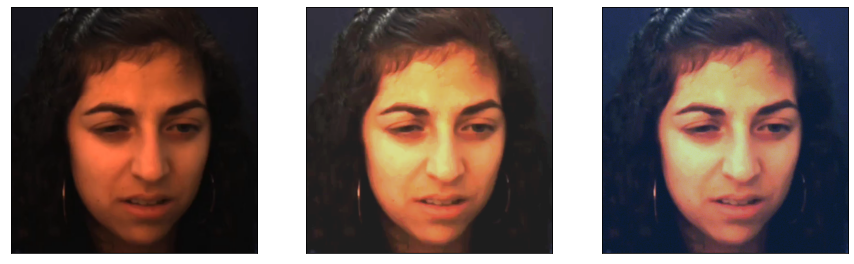

./stimuli_new_tint/id4d1.mp4


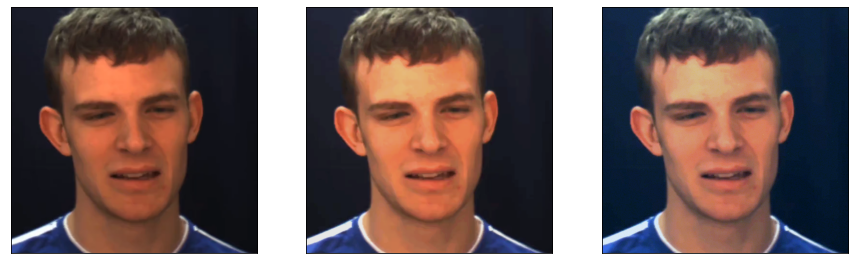

./stimuli_new_tint/id5d1.mp4


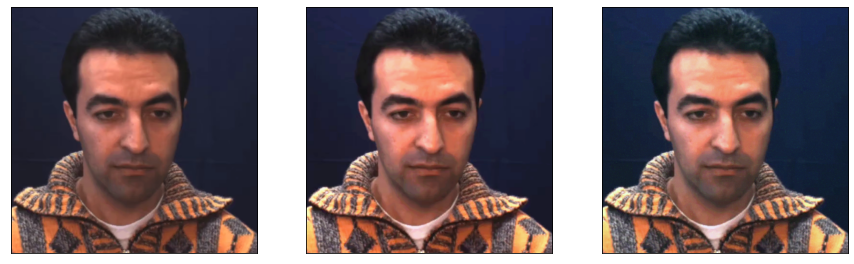

./stimuli_new_tint/id6d1.mp4


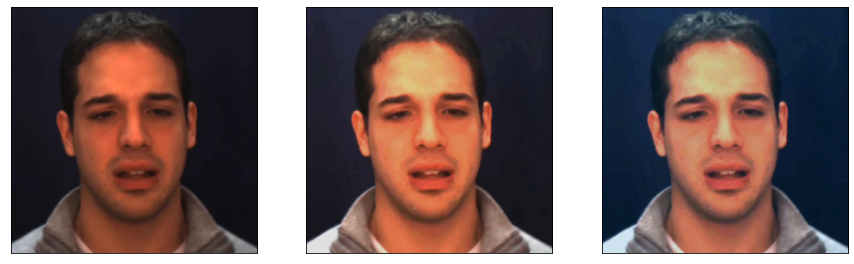

./stimuli_new_tint/id7d1.mp4


In [927]:
col = []
for i in np.arange(0,70,10):
    
    videodata = load_video(files[i])
    frame_orig = videodata[0,:,:,:].copy()
    
    for j in range(25):
        contrast = videodata[0,:,:,:].mean(axis=-1).std()
        brightness = videodata[0,:,:,:].mean()
        
        videodata = contrast_video(videodata,contrast_target/contrast)
        videodata = brighten_video(videodata,brightness_target/brightness)
    
    frame_bw = videodata[0,:,:,:].copy()
    
    frame = videodata[0,:,:,:]
    new_frame = adjust_frame_tint(frame,ctargets)
    
    col.append(new_frame)

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1);plt.imshow(frame_orig);plt.xticks([]);plt.yticks([]);
    plt.subplot(1,3,2);plt.imshow(frame_bw);plt.xticks([]);plt.yticks([]);
    plt.subplot(1,3,3);plt.imshow(new_frame);plt.xticks([]);plt.yticks([]);
    plt.show()
    
    
    videodata = np.array([adjust_frame_tint(videodata[i,:,:,:],ctargets) for i in range(videodata.shape[0])])
    save_video(videodata,files[i].replace('stimuli_cropped','stimuli_new_tint'))
    print(files[i].replace('stimuli_cropped','stimuli_new_tint'))

In [976]:
col = np.array(col)

In [977]:
col.shape

(7, 512, 512, 3)

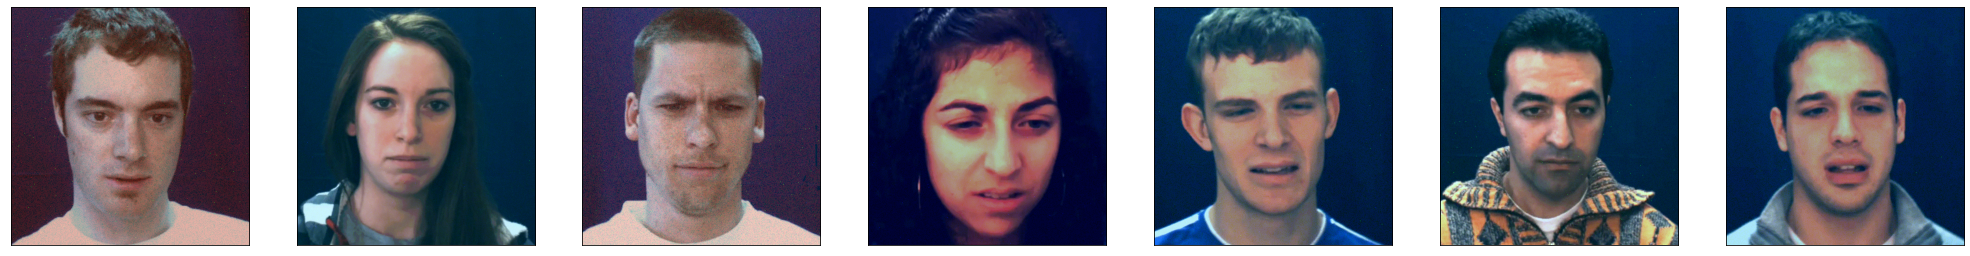

In [978]:
plt.figure(figsize=(5*7,5))
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.imshow(col[i,:,:,:])
    plt.xticks([]);
    plt.yticks([]);

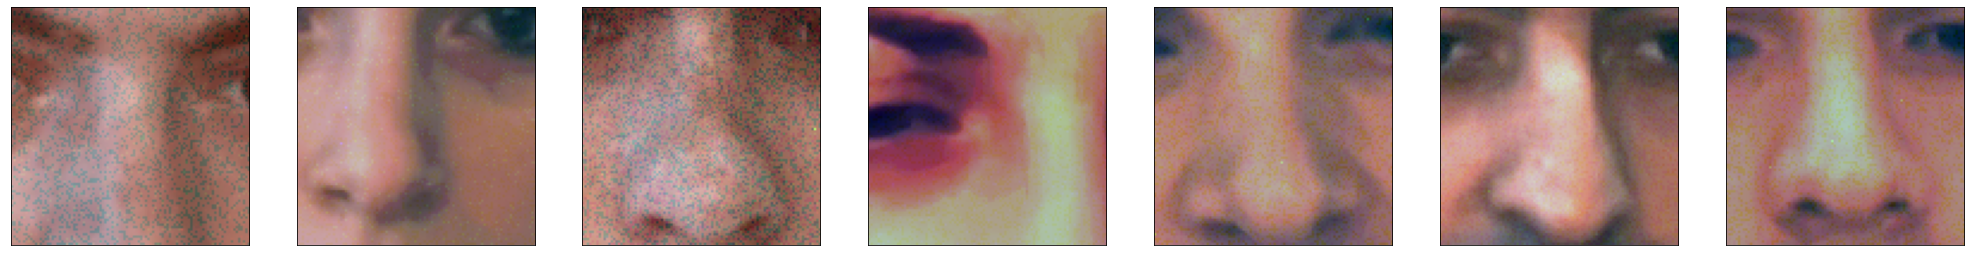

In [983]:
plt.figure(figsize=(5*7,5))
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.imshow(get_face(col[i,:,:,:]))
    plt.xticks([]);
    plt.yticks([]);

In [984]:
[get_face(col[c,:,:,:]).sum(axis=0).sum(axis=0) for c in range(7)]

[array([1496810, 1146717, 1073327], dtype=uint64),
 array([1496810, 1146717, 1073327], dtype=uint64),
 array([1496810, 1146717, 1073327], dtype=uint64),
 array([1496810, 1146717, 1073327], dtype=uint64),
 array([1496810, 1146717, 1073327], dtype=uint64),
 array([1496810, 1146717, 1073327], dtype=uint64),
 array([1496810, 1146717, 1073327], dtype=uint64)]

In [980]:
[col[c,:,:,:].sum(axis=0).sum(axis=0) for c in range(7)]

[array([26817835, 20330654, 21753260], dtype=uint64),
 array([13765213, 18659436, 21821931], dtype=uint64),
 array([27700465, 23057473, 26829185], dtype=uint64),
 array([15341608, 12046171, 19437758], dtype=uint64),
 array([16313108, 19809102, 24886488], dtype=uint64),
 array([16042817, 19731794, 23048066], dtype=uint64),
 array([15513693, 19049261, 24701039], dtype=uint64)]

In [981]:
[col[c,:,:,:].std() for c in range(7)]

[54.36175209066711,
 55.007692233700325,
 55.513084008672756,
 55.73931254590235,
 55.59124654202601,
 56.423706143636764,
 55.27202916942518]

In [982]:
[col[c,:,:,:].mean() for c in range(7)]

[87.61310450236003,
 68.97809346516927,
 98.65712865193684,
 59.54174931844076,
 77.57657114664714,
 74.79690170288086,
 75.35806401570638]